## 0) Load libraries

In [11]:
""" Basics """
import os
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

""" MCMC """
import pymc3 as pm
import theano.tensor as tt

""" Web """
import requests
from lxml import html, etree

""" Plotting """
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.core.pylabtools import figsize

## 1) Retrieve top players

In [12]:
'''
xpath  = """//*[@class="format_cell detail_list_player"]/a[2]/text()"""
page   = requests.get("https://www.esportsearnings.com/games/151-starcraft-ii/top-players")
tree   = html.fromstring(page.content)
top100 = tree.xpath(xpath)
top9  = top100[:9]
print(top9)
'''

#top9 = ['Maru', 'Rogue', 'sOs', 'TY', 'INnoVation', 'Life'] #, 'MC', 'Serral', 'Stats'
top9 = ['Stats', 'INnoVation', 'Dark', 'soO', 'TY', 'GuMiho', 'herO', 'Rogue']

In [27]:
xpath = "//tr/td[@align = 'left']/a/text()"
page = requests.get("https://liquipedia.net/starcraft2/2017_StarCraft_II_World_Championship_Series_Korea/Standings")
tree = html.fromstring(page.content)
top  = tree.xpath(xpath)
top9 = top[:8]

In [3]:
top9

['Stats', 'INnoVation', 'Dark', 'soO', 'TY', 'GuMiho', 'herO', 'Rogue']

## 2) Load and clean match data

In [13]:
data = pd.read_csv('sc2-matches-history.csv')
print("Rows: {}".format(len(data)))
print("Unique players: {}".format(len(data['player_1'].unique())))
data.head(10)

Rows: 374794
Unique players: 1856


,match_date,player_1,player_1_match_status,score,player_2,player_2_match_status,player_1_race,player_2_race,addon,tournament_type
0,09/19/2016,MC,[loser],0–2,Stats,[winner],P,P,LotV,online
1,09/19/2016,MC,[winner],2–1,NaTuRal,[loser],P,T,LotV,online
2,09/19/2016,MC,[loser],1–2,Dark,[winner],P,Z,LotV,online
3,09/13/2016,MC,[loser],0–2,INnoVation,[winner],P,T,LotV,online
4,08/27/2016,MC,[loser],0–1,TRUE,[winner],P,Z,LotV,online
5,07/17/2016,MC,[loser],0–1,Cure,[winner],P,T,LotV,offline
6,07/16/2016,MC,[winner],1–0,Super,[loser],P,P,LotV,offline
7,07/16/2016,MC,[winner],1–0,aLive,[loser],P,T,LotV,offline
8,07/16/2016,MC,[winner],1–0,Curious,[loser],P,Z,LotV,offline
9,07/06/2016,MC,[loser],0–2,Zest,[winner],P,P,LotV,offline


### 2.0) Subset players and format score

In [14]:
data = data[data['player_1'].isin(top9)]
data = data[data['player_2'].isin(top9)]
assert(len(data['player_1'].unique()) == len(top9))
assert(len(data['player_2'].unique()) == len(top9))

def extract_score(row, player):
    if player == 1:
        score = row[0]
    elif player == 2:
        score = row[2]
    return(int(score))

data['score_1'] = data['score'].apply(lambda x: extract_score(x, 1))
data['score_2'] = data['score'].apply(lambda x: extract_score(x, 2))

data.drop(['player_1_match_status', 
           'score', 
           'player_2_match_status', 
           'addon', 
           'tournament_type'], 
          axis=1, inplace=True)

### 2.1) Format date

In [15]:
data.match_date = pd.to_datetime(data.match_date)
data = data.sort_values(by = ['match_date'])

### 2.2) Create key-value pairs for players

In [16]:
players      = data['player_1'].unique()
players      = pd.DataFrame(players, columns=['players'])
players['i'] = players.index
playerd = players.to_dict()
playerd = playerd['players']
playerd

{0: 'INnoVation',
 1: 'soO',
 2: 'herO',
 3: 'Rogue',
 4: 'TY',
 5: 'Stats',
 6: 'GuMiho',
 7: 'Dark'}

In [17]:
data = pd.merge(data, players, left_on='player_1', right_on='players', how='left')
data = data.rename(columns = {'i': 'i_player_1'}).drop('players', 1)
data = pd.merge(data, players, left_on='player_2', right_on='players', how='left')
data = data.rename(columns = {'i': 'i_player_2'}).drop('players', 1)
data.head(10)

,match_date,player_1,player_2,player_1_race,player_2_race,score_1,score_2,i_player_1,i_player_2
0,2012-07-15,INnoVation,soO,T,Z,0,1,0,1
1,2012-07-15,soO,INnoVation,Z,T,1,0,1,0
2,2012-07-19,herO,INnoVation,P,T,1,2,2,0
3,2012-07-19,INnoVation,herO,T,P,2,1,0,2
4,2012-08-12,Rogue,soO,Z,Z,1,0,3,1
5,2012-08-12,soO,Rogue,Z,Z,0,1,1,3
6,2012-09-09,soO,herO,Z,P,0,1,1,2
7,2012-09-09,herO,soO,P,Z,1,0,2,1
8,2012-10-22,TY,soO,T,Z,1,4,4,1
9,2012-10-22,soO,TY,Z,T,4,1,1,4


### 2.3) Remove sparse dates

In [19]:
dates = [min(data.match_date), "2014-01-01", "2015-01-01", "2016-01-01", "2017-01-01"]
for date in dates:
    print("GEQ {}: {}".format(date, len(data[data['match_date'] >= pd.to_datetime(date)])))
data = data[data['match_date'] >= pd.to_datetime(dates[3])]

GEQ 2016-01-13 00:00:00: 661
GEQ 2014-01-01: 661
GEQ 2015-01-01: 661
GEQ 2016-01-01: 661
GEQ 2017-01-01: 471


### 2.4) Plot player performance

In [23]:
def plot_multi(player, data, i, ax):
    sumdata = data.copy()
    sumdata = sumdata[sumdata['player_1'] == player]
    sumdata['cumsum_1'], sumdata['cumsum_2'] = sumdata['score_1'].cumsum(), sumdata['score_2'].cumsum()
    ax[i].plot(sumdata['cumsum_1'], sumdata['cumsum_2'])
    ax[i].set_title(player)
    ax[i].set_xlabel('Attack')
    ax[i].set_ylabel('Defense')
    del(sumdata)

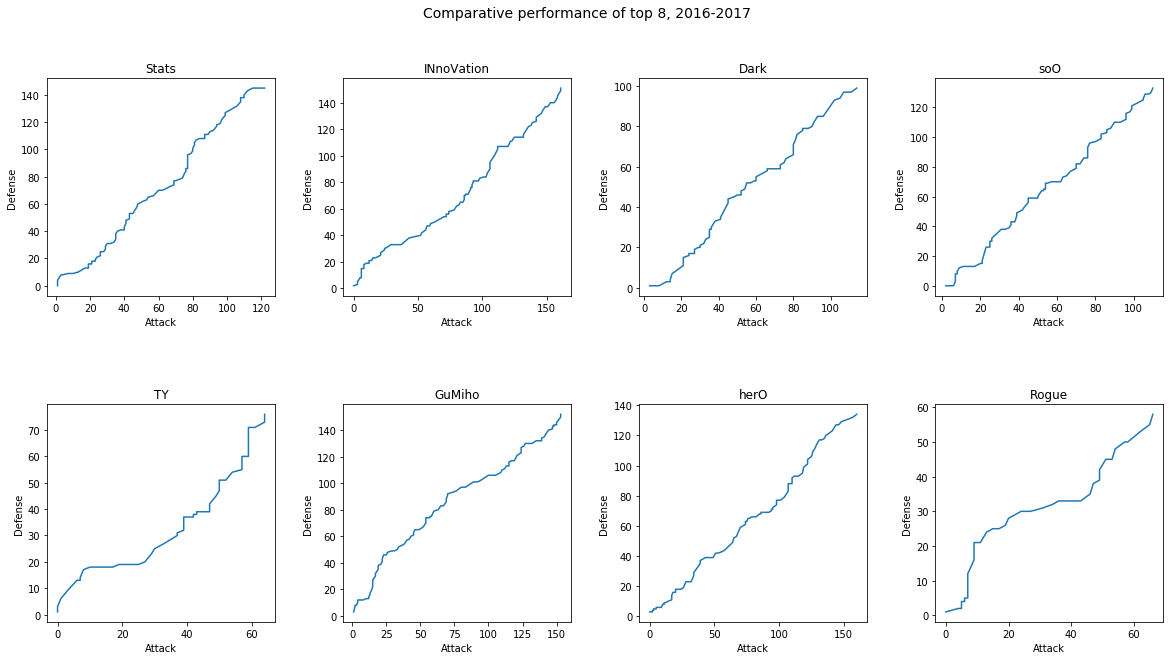

In [24]:
fig, axs = plt.subplots(2,4, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
i = 0

for player in top9:
    plot_multi(player, data, i, axs)
    i += 1
fig.suptitle("Comparative performance of top 8, 2016-2017", fontsize = 14)
    
fig.savefig('subplot_2.png')

### 2.5) Inspect Player match fraction

In [25]:
l = []
def print_rel(player, data):
    t = len(data)
    k = len(data[data['player_1'] == player])
    print("{}:\t {}".format(player, k/t))
    l.append(k/t)
    
for player in top9:
    print_rel(player, data)

Stats:	 0.14977307110438728
INnoVation:	 0.15279878971255673
Dark:	 0.11800302571860817
soO:	 0.12405446293494705
TY:	 0.08169440242057488
GuMiho:	 0.15431164901664146
herO:	 0.15128593040847202
Rogue:	 0.0680786686838124


In [26]:
observed_player1_score = data.score_1.values
observed_player2_score = data.score_2.values
player_1               = data.i_player_1.values
player_2               = data.i_player_2.values
n_players              = len(data.player_1.unique())
n_games                = len(player_1)
print("{} players, {} games".format(n_players, n_games))

8 players, 661 games


### 2.6) Inspect player mean scores

In [27]:
g = data.groupby('i_player_1')
p1_start = np.log(g.score_1.mean())
g = data.groupby('i_player_2')
p2_start = np.log(g.score_1.mean())
p1_start, p2_start

(i_player_1
 0    0.466284
 1    0.293761
 2    0.470004
 3    0.382992
 4    0.169899
 5    0.208901
 6    0.405465
 7    0.379490
 Name: score_1, dtype: float64, i_player_2
 0    0.402159
 1    0.483630
 2    0.302720
 3    0.253781
 4    0.341749
 5    0.385262
 6    0.398908
 7    0.238411
 Name: score_1, dtype: float64)

## 3) Model

### 3.1) Basline model:

#### 3.1.1) Model Setup

In [54]:
with pm.Model() as base_model:
    tau_att    = pm.Gamma('tau_att', 0.1, 0.1) # Distribution of stdev, attack
    tau_def    = pm.Gamma('tau_def', 0.1, 0.1) # Distribution of stdev, defense

    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = 0, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = 0, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(atts[player_1] + defs[player_2])
    p2_theta = tt.exp(atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

#### 3.1.2) Sample

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, tau_def, tau_att]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1263.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


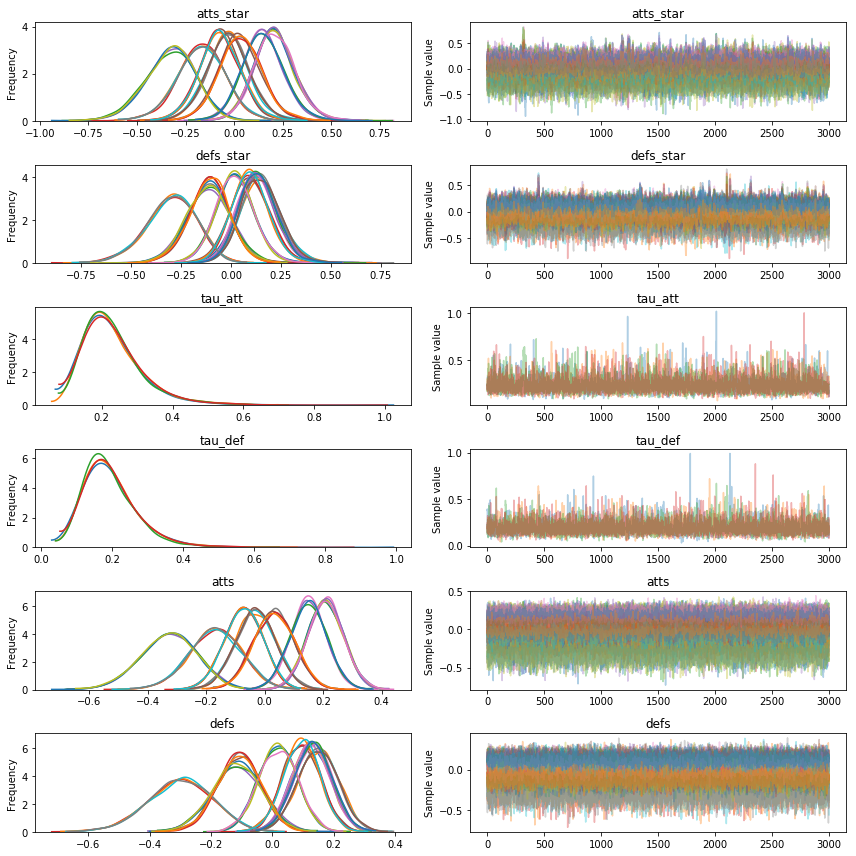

In [55]:
with base_model:
    trace = pm.sample(5000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

#### 3.1.3) Evaluate Specification & Convergence

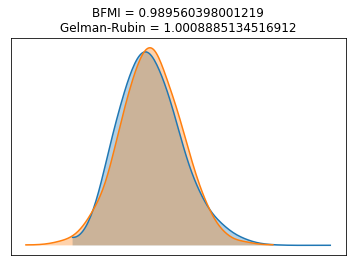

In [56]:
bfmi = pm.bfmi(burned_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(burned_trace).values())
(pm.energyplot(burned_trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

### 3.2) Intercept Model

#### 3.2.1) Model Specification

In [32]:
with pm.Model() as intercept_model:
    # global model parameters
    #mu_att     = pm.Normal('mu_att', 0, 0.5)  # Distribution of mean, attack
    #mu_def     = pm.Normal('mu_def', 0, 0.5)  # Distribution of mean, defense
    #tau_att    = pm.HalfStudentT('tau_att', nu = 10, sd = 0.9) # Distribution of stdev, attack
    #tau_def    = pm.HalfStudentT('tau_def', nu = 10, sd = 0.9) # Distribution of stdev, defense
    tau_att    = pm.Gamma('tau_att', 0.1, 0.1) # Distribution of stdev, attack
    tau_def    = pm.Gamma('tau_def', 0.1, 0.1) # Distribution of stdev, defense
    intercept  = pm.Flat('intercept')            # Tuneable intercept

    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = 0, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = 0, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(intercept + atts[player_1] + defs[player_2])
    p2_theta = tt.exp(intercept + atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

#### 3.2.2) Sample

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, tau_def, tau_att]
Sampling 4 chains: 100%|██████████| 22000/22000 [02:39<00:00, 138.00draws/s] 
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.9. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8066520471665622, but should be close to 0.9. Try to increase the number of tuning steps.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6762110268412062, but should be close to 0.9. Try to increase

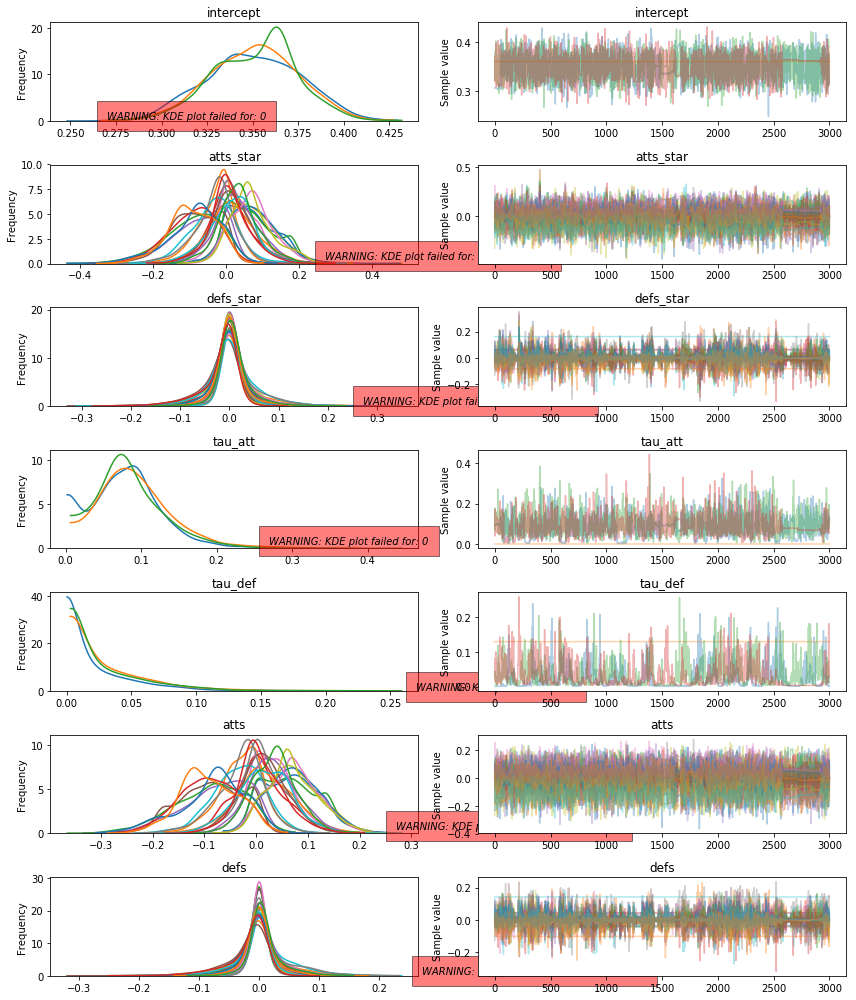

In [33]:
with intercept_model:
    trace = pm.sample(5000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

#### 3.2.3) Evaluate Specification & Convergence

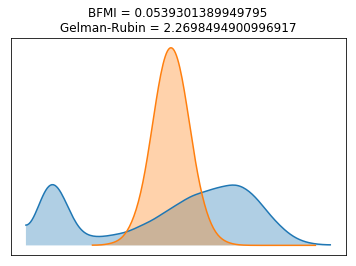

In [34]:
bfmi = pm.bfmi(burned_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(burned_trace).values())
(pm.energyplot(burned_trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

### 3.3) Tunable Mean Model wo. Intercept

#### 3.3.1) Model Specification

In [51]:
with pm.Model() as mean_model:
    # global model parameters
    mu_att     = pm.Normal('mu_att', 0)  # Distribution of mean, attack
    mu_def     = pm.Normal('mu_def', 0)  # Distribution of mean, defense
    tau_att    = pm.Gamma('tau_att', 0.1, 0.1) # Distribution of stdev, attack
    tau_def    = pm.Gamma('tau_def', 0.1, 0.1) # Distribution of stdev, defense
    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = mu_att, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = mu_def, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(atts[player_1] + defs[player_2])
    p2_theta = tt.exp(atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

#### 3.3.2) Sample

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, tau_def, tau_att, mu_def, mu_att]
Sampling 4 chains: 100%|██████████| 42000/42000 [04:28<00:00, 156.24draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


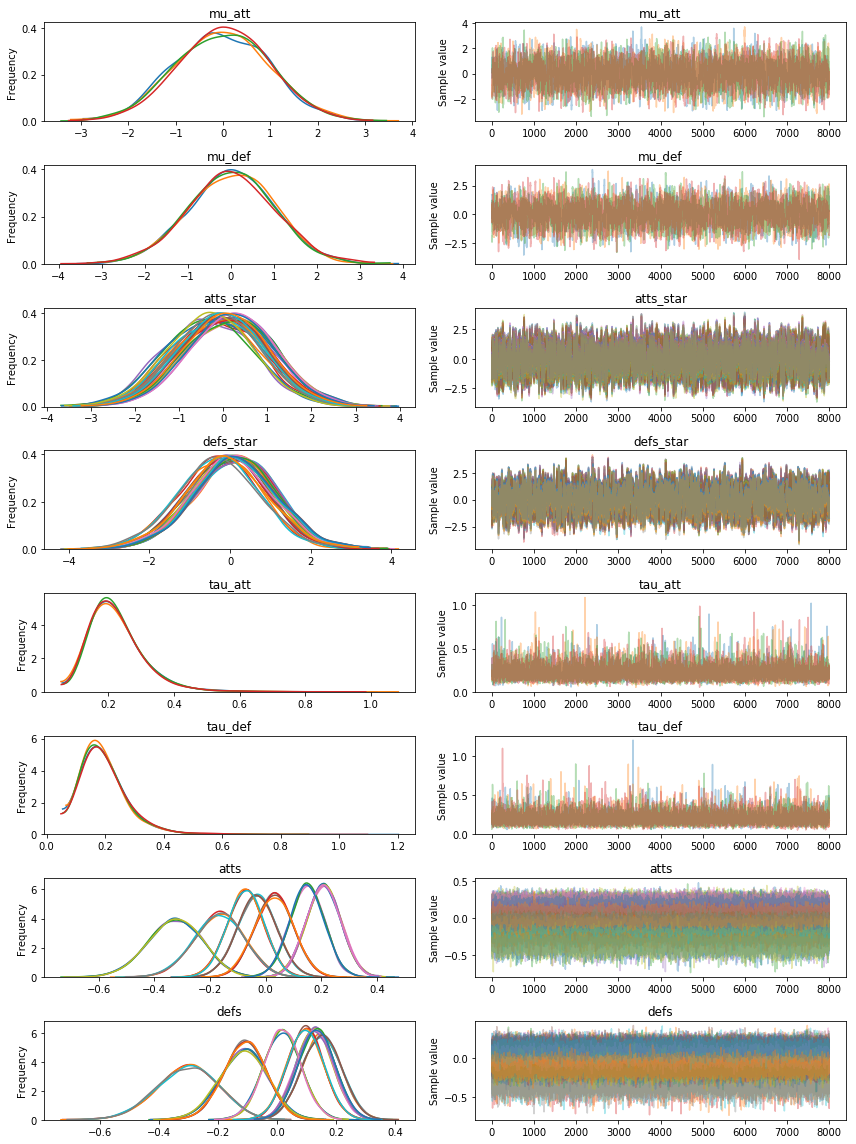

In [52]:
with mean_model:
    trace = pm.sample(10000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

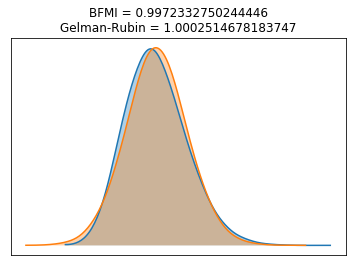

In [53]:
bfmi = pm.bfmi(burned_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(burned_trace).values())
(pm.energyplot(burned_trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

### 3.4) HalfStudent Distributed Variance

#### 3.4.1) Model Specification

In [ ]:
with pm.Model() as intercept_model:
    tau_att    = pm.HalfStudentT('tau_att', nu = 10, sd = 0.9) # Distribution of stdev, attack
    tau_def    = pm.HalfStudentT('tau_def', nu = 10, sd = 0.9) # Distribution of stdev, defense
    intercept  = pm.Flat('intercept')            # Tuneable intercept

    # player-specific model parameters
    atts_star = pm.Normal("atts_star", mu = 0, sd = tau_att, shape = n_players) #
    defs_star = pm.Normal("defs_star", mu = 0, sd = tau_def, shape = n_players) #

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    p1_theta = tt.exp(intercept + atts[player_1] + defs[player_2])
    p2_theta = tt.exp(intercept + atts[player_2] + defs[player_1])

    # likelihood of observed data
    p1_points = pm.Poisson('p1_points', mu = p1_theta, observed = observed_player1_score)
    p2_points = pm.Poisson('p2_points', mu = p2_theta, observed = observed_player2_score)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, tau_def, tau_att, mu_def, mu_att]
Sampling 4 chains: 100%|██████████| 42000/42000 [04:10<00:00, 167.45draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


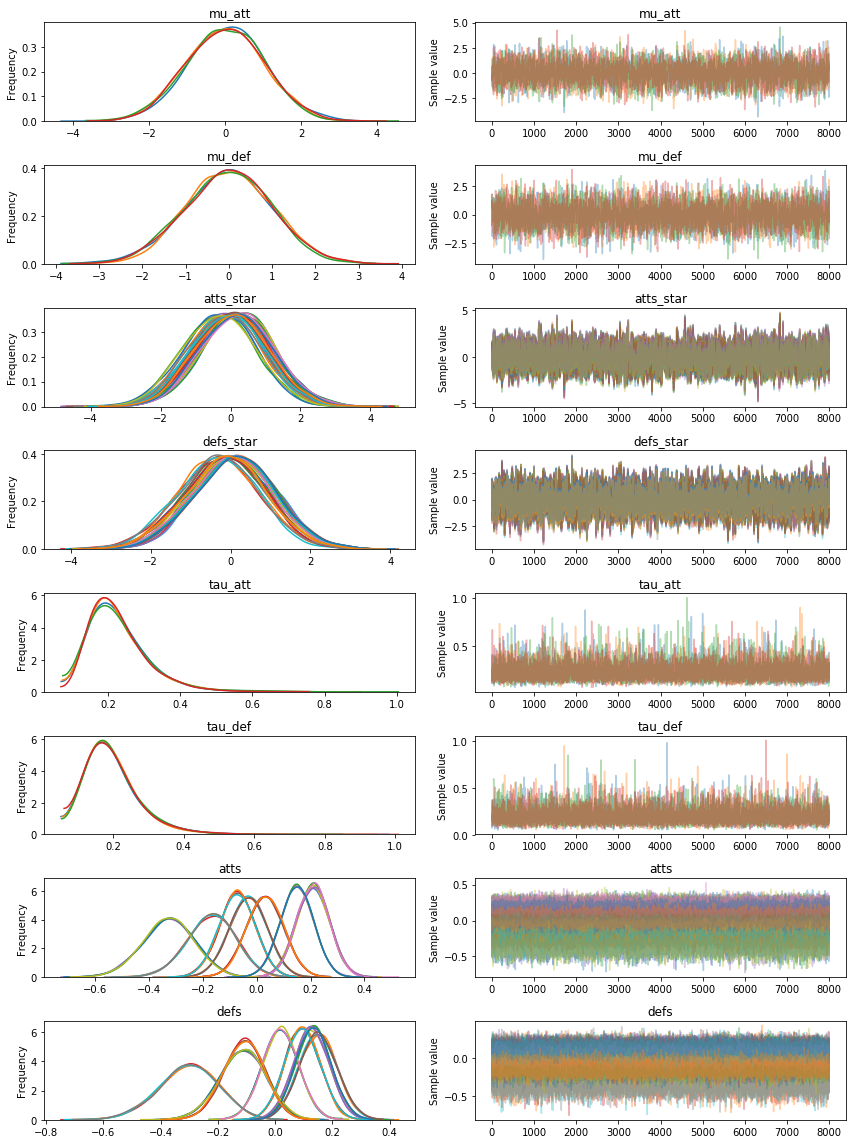

In [49]:
with mean_model:
    trace = pm.sample(10000, tune = 500, nuts_kwargs = {'target_accept': 0.90}, cores = 4)
    burned_trace = trace[2000:]
    pm.traceplot(burned_trace)

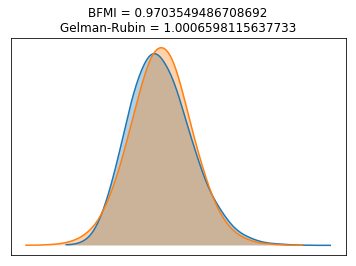

In [50]:
bfmi = pm.bfmi(burned_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(burned_trace).values())
(pm.energyplot(burned_trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

## 4) Predict

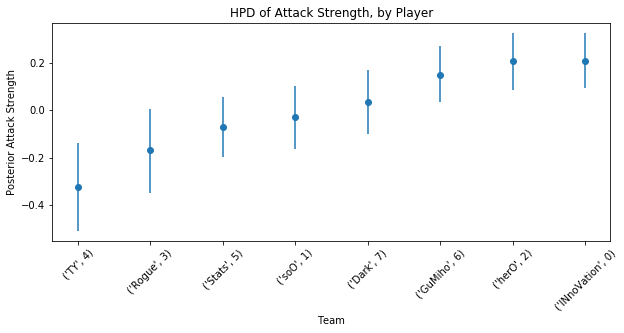

In [57]:
df_hpd = pd.DataFrame(pm.stats.hpd(burned_trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=players.values)
df_median = pd.DataFrame(pm.stats.quantiles(burned_trace['atts'])[50],
                         columns=['hpd_median'],
                         index=players.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Player')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

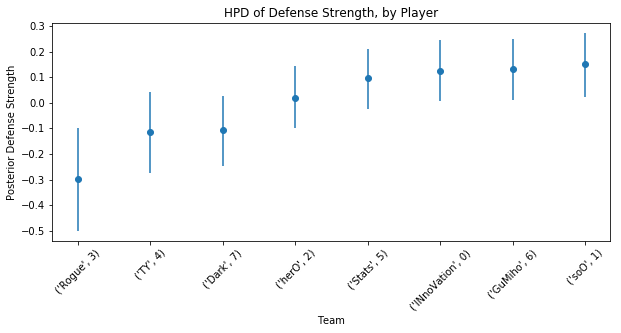

In [58]:
df_hpd = pd.DataFrame(pm.stats.hpd(burned_trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=players.values)
df_median = pd.DataFrame(pm.stats.quantiles(burned_trace['defs'])[50],
                         columns=['hpd_median'],
                         index=players.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defense Strength, by Player')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

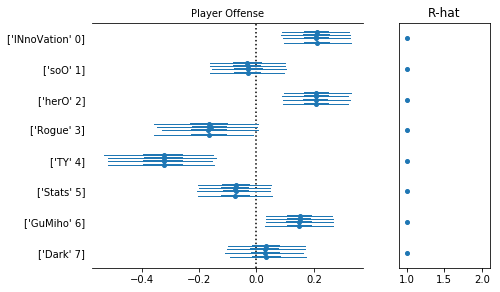

In [232]:
pm.forestplot(burned_trace, varnames=['atts'], ylabels=players.values, main="Player Offense")

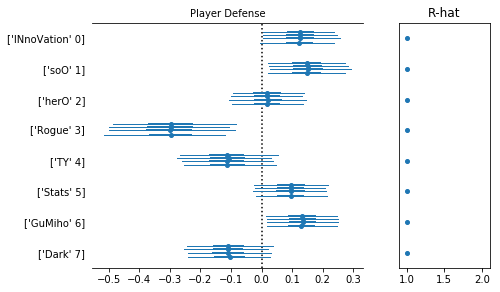

In [233]:
pm.forestplot(burned_trace, varnames=['defs'], ylabels=players.values, main="Player Defense")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d10d47860>,
      dtype=object)

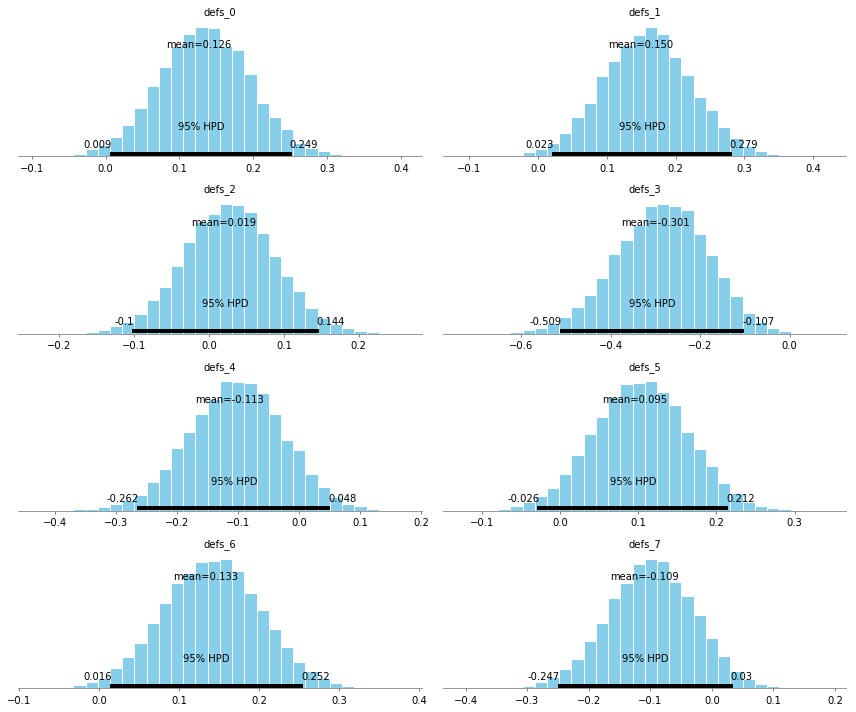

In [234]:
pm.plot_posterior(trace, varnames=['defs'])

In [59]:
with base_model:
    pp_trace = pm.sampling.sample_ppc(burned_trace)

100%|██████████| 3000/3000 [00:03<00:00, 986.26it/s]


In [60]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): home_won
        for i, home_won in enumerate(pp_trace['p1_points'] > pp_trace['p2_points'])
})
home_sim_df.insert(0, 'player', data['player_1'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): away_won
        for i, away_won in enumerate(pp_trace['p1_points'] < pp_trace['p2_points'])
})
away_sim_df.insert(0, 'player', data['player_2'])
sim_table = (home_sim_df.groupby('player')
                        .sum()
                        .add(away_sim_df.groupby('player')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='player', value_name='rank')
                        .groupby('player')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
player,,,,,,,,
Dark,0.069,0.202,0.403,0.718,1.148,0.449,0.011,0.000
GuMiho,0.519,0.675,0.784,0.628,0.320,0.073,0.001,0.000
INnoVation,0.294,0.515,0.710,0.776,0.535,0.170,0.000,0.000
Rogue,0.000,0.000,0.000,0.000,0.000,0.000,0.126,2.874
Stats,1.604,0.741,0.386,0.203,0.053,0.013,0.000,0.000
TY,0.000,0.000,0.000,0.001,0.008,0.146,2.763,0.082
herO,0.789,0.940,0.650,0.396,0.188,0.037,0.000,0.000
soO,0.001,0.022,0.071,0.235,0.641,1.948,0.082,0.000


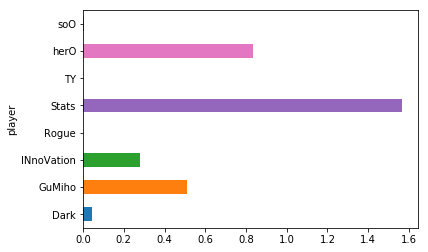

In [251]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

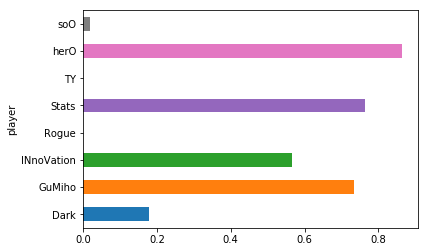

In [248]:
ax = sim_table.loc[:, 2.0].plot(kind='barh')